# Q-Learning, Deep Q-learning (DQN) and double Deep Q-learning (DDQN)

## This notebook shows how to apply difference Q-Learning to the grid word example

In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import torch
from torch.autograd import Variable
from Gridworld import *
from IPython.display import clear_output
import random
from matplotlib import pylab as plt

#### setup the gridworld game. + is the goal, - is the pit, W is the wall and P is the playe. Use game.display() to show the environment
#### Note the starting reward is -1

In [2]:
from Gridworld import *

game = Gridworld (size=4, mode="static")

print(game.display())
print(game.reward())

[['+' '-' ' ' 'P']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
-1


We can move using 'd' 'u' 'l' and 'r' to move donw, up , left and right

In [3]:
game.makeMove('d')
game.makeMove('d')
game.makeMove('l')
game.makeMove('l')


print(game.display())
print(game.reward())


[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ']]
-1


A sample moves to resolve the grid world

In [4]:
game.makeMove('l')

game.makeMove('l')
game.makeMove('u')

print(game.display())
print(game.reward())

[['+' '-' ' ' ' ']
 ['P' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
-1


In [5]:
game.board.render_np()

array([[[0, 0, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[1, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)

In [56]:
def running_mean(x, N=500):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [6]:
def testModel(model, mode='static', display= True):
    epsilon = 0.05
    max_moves = 50
    win = False
    action_num = 0
    test_game = Gridworld(mode=mode)
    state_ = test_game.board.render_np().reshape(1, 64) + np.random.rand(1, 64)/10.0
    state = Variable(torch.from_numpy(state_).float())
    if display:
        print("Initial State:")
        print(test_game.display())
    finished = False
    while not finished:
        qval = model(state)
        qval_ = qval.data.numpy()
        if (random.random() < epsilon):
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)
        action = action_set[action_]
        if display:
            print("Move # : %s; taking action: %s" % (action_num, action))
        test_game.makeMove(action)
        state_ = test_game.board.render_np().reshape(1, 64) + np.random.rand(1, 64)/10.0
        state = Variable(torch.from_numpy(state_).float())
        if display:
            print(test_game.display())
        reward = test_game.reward()
        if reward == 10:
            finished = True
            win = True
            if display:
                print("You won! Reward: {}".format(reward,))
        elif reward == -10:
            finished = True
            if display:
                print("Game lost; stepped into the pit. Penalty: {}".format(reward,))
        action_num += 1
        if (action_num > max_moves):
            if display:
                print("Game lost, too many moves")
            break
    return win


In [7]:
def test_win_perc(model, max_games=1000):
    wins = 0
    for i in range(max_games):
        win = testModel(model, 'random', display=False)
        if win:
            win +=1
    win_perc = float(wins) / float(max_games)
    print("Games player: {0}, # of wins: ${1}".format(max_games, wins))
    print("Win precentage: {}".format(win_perc))

## Deep Q-Learning

In [16]:
# Hyperparameters
learning_rate = 1e-4
gamma = 0.9 
epsilon = 1.0

In [17]:
loss_fn = torch.nn.MSELoss(size_average =False)

# code action_set using number
action_set = {
    0: "u",
    1: "d",
    2: "l",
    3: "r",
}

/Users/siweiwang/anaconda3/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [18]:
l1 = 64
l2 = 164
l3 = 150
l4 = 4

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3, l4)
)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


# code action_set using number
action_set = {
    0: "u",
    1: "d",
    2: "l",
    3: "r",
}

In [9]:
epochs = 1000
losses = []
for i in range(epochs):
    game = Gridworld(size=4, mode ="static")
    state_ = game.board.render_np().reshape(1, 64) + np.random.rand(1,64)/10.0
    state = Variable(torch.from_numpy(state_).float())
    finished = False
    while not finished:
        qval = model(state)
        qval_ = qval.data.numpy()
        if(random.random() < epsilon):
            action_ = np.random.randint(0,4)
        else:
            action_ = (np.argmax(qval_))
        action = action_set[action_]
        game.makeMove(action)
        new_state_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64)/10.0
        new_state = Variable(torch.from_numpy(new_state_).float())
        reward = game.reward()
        newQ= model(new_state.reshape(1, 64)).data.numpy()
        maxQ= np.max(newQ)
        y = np.zeros((1,4))
        y[:] = qval_[:]
        if reward == -1:
            update = (reward + (gamma * maxQ))
        else:
            update = reward
        y[0][action_] = update 
        y = Variable(torch.from_numpy(y).float())
        loss = loss_fn(qval, y)
        print(i, loss.item())
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.data)
        optimizer.step()
        state = new_state
        if reward != -1:
            finished = True
        clear_output(wait=True)
    if epsilon > 0.1:
        epsilon -= (1/epochs)

999 0.001472120638936758


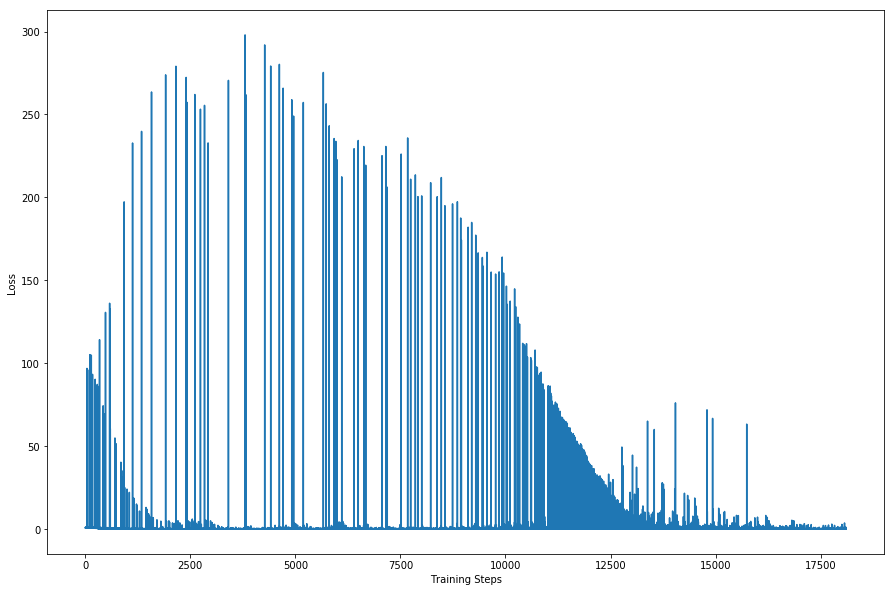

In [22]:
plt.figure(figsize=(15,10))
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.plot(losses)
plt.savefig("dqn_1_loss_plot.pdf", format="pdf")


In [11]:
testModel(model, 'static')

Initial State:
[['+' '-' ' ' 'P']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move # : 0; taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' 'P']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move # : 1; taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' 'P']
 [' ' ' ' ' ' ' ']]
Move # : 2; taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']]
Move # : 3; taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move # : 4; taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 ['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move # : 5; taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['P' ' ' ' ' ' ']]
Move # : 6; taking action: u
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 ['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move # : 7; taking action: u
[['+' '-' ' ' ' ']
 ['P' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move # : 8; taking action: u
[['+' '-' ' ' ' ']
 [' ' 'W' ' 

True

### Test Model Accuracy for static world

In [12]:
max_games = 1000
wins = 0
for i in range(max_games):
    win = testModel(model, 'static', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}".format(win_perc))

Games played: 1000, # of wins: 1000
Win percentage: 1.0


### Test Model Accuracy for random world

In [15]:
max_games = 1000
wins = 0
for i in range(max_games):
    win = testModel(model, 'random', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}".format(win_perc))

Games played: 1000, # of wins: 226
Win percentage: 0.226


### Experience Replay

In [50]:
l1 = 64
l2 = 200
l3 = 150
l4 = 100
l5 = 4

model2 = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4),
    torch.nn.ReLU(),
    torch.nn.Linear(l4,l5)
)

loss_fn2 = torch.nn.MSELoss(size_average=False)

learning_rate2 = 1e-4
optimizer2 = torch.optim.Adam(model2.parameters(), lr=learning_rate2)

gamma = 0.9 #since it may take several moves to goal, making gamma high
epsilon = 1.0

action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}


/Users/siweiwang/anaconda3/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [51]:
epochs = 1500
losses =[]
batchSize = 40
buffer = 80
replay = []
max_moves =75

for i in range(epochs):
    game = Gridworld(size=4, mode ="random")
    state_ = game.board.render_np().reshape(1, 64) + np.random.rand(1,64)/10.0
    state = Variable(torch.from_numpy(state_).float())
    finished = False
    action_count = 0
    while not finished:
        action_count +=1
        qval = model2(state)
        qval_ = qval.data.numpy()
        if(random.random() < epsilon):
            action_ = np.random.randint(0,4)
        else:
            action_ = (np.argmax(qval_))

        action = action_set[action_]
        game.makeMove(action)
        new_state_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64)/10.0
        new_state = Variable(torch.from_numpy(new_state_).float())
        reward = game.reward()
        
        if (len(replay) < buffer):
            replay.append((state, action_, reward, new_state))
        else:
            replay.pop(0)
            replay.append((state, action_, reward, new_state))
            minibatch = random.sample(replay, batchSize)
    
            x_train = Variable(torch.empty(batchSize, 4, dtype=torch.float))
            y_train = Variable(torch.empty(batchSize, 4, dtype=torch.float))
            h = 0
            for memory in minibatch:
                old_state, action_m, reward_m, new_state_m = memory
                old_qval = model2(old_state)
                newQ = model2(new_state_m).data.numpy()
                maxQ = np.max(newQ)
                y = torch.zeros((1,4))
                y[:] = old_qval[:]
                if reward == -1:
                    update = (reward_m + (gamma * maxQ))
                else:
                    update = reward_m
                y[0][action_m] = update
                x_train[h] = old_qval
                y_train[h] = Variable(y)
                h += 1
                
            loss = loss_fn2(x_train, y_train)
            print(i, loss.item())
            optimizer2.zero_grad()
            loss.backward()
            losses.append(loss.data)
            optimizer2.step()

            state = new_state
        if reward != -1 or action_count > max_moves:
            finished = True
            action_count = 0
        clear_output(wait=True)
    if epsilon > 0.1:
        epsilon -= (1/epochs)

1499 1127.546630859375


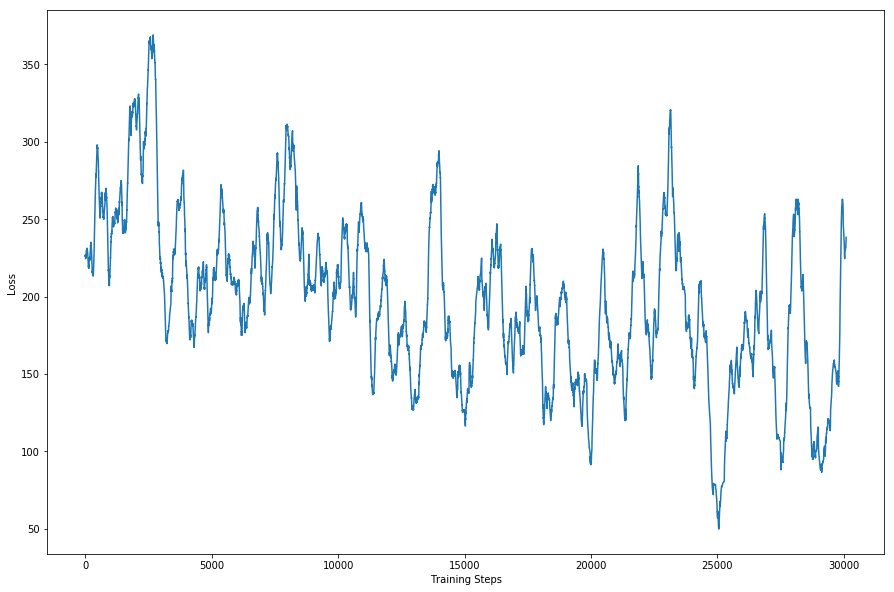

In [57]:
plt.figure(figsize=(15,10))
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.plot(running_mean(losses))
plt.savefig("dqn_2_loss_plot.pdf", format="pdf")


In [54]:
testModel(model2, 'random')

Initial State:
[[' ' ' ' ' ' 'W']
 [' ' ' ' ' ' '-']
 [' ' ' ' ' ' '+']
 ['P' ' ' ' ' ' ']]
Move # : 0; taking action: r
[[' ' ' ' ' ' 'W']
 [' ' ' ' ' ' '-']
 [' ' ' ' ' ' '+']
 [' ' 'P' ' ' ' ']]
Move # : 1; taking action: r
[[' ' ' ' ' ' 'W']
 [' ' ' ' ' ' '-']
 [' ' ' ' ' ' '+']
 [' ' ' ' 'P' ' ']]
Move # : 2; taking action: r
[[' ' ' ' ' ' 'W']
 [' ' ' ' ' ' '-']
 [' ' ' ' ' ' '+']
 [' ' ' ' ' ' 'P']]
Move # : 3; taking action: r
[[' ' ' ' ' ' 'W']
 [' ' ' ' ' ' '-']
 [' ' ' ' ' ' '+']
 [' ' ' ' ' ' 'P']]
Move # : 4; taking action: r
[[' ' ' ' ' ' 'W']
 [' ' ' ' ' ' '-']
 [' ' ' ' ' ' '+']
 [' ' ' ' ' ' 'P']]
Move # : 5; taking action: u
[[' ' ' ' ' ' 'W']
 [' ' ' ' ' ' '-']
 [' ' ' ' ' ' '+']
 [' ' ' ' ' ' ' ']]
You won! Reward: 10


True

In [55]:
max_games = 1000
wins = 0
for i in range(max_games):
    win = testModel(model2, 'random', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}".format(win_perc))

Games played: 1000, # of wins: 572
Win percentage: 0.572


## Experience replay and target network

In [74]:
import copy

l1 = 64
l2 = 164
l3 = 150
l4 = 100
l5 = 4

model3 = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4),
    torch.nn.ReLU(),
    torch.nn.Linear(l4,l5)
)

model3_target = copy.deepcopy(model3)

loss_fn3 = torch.nn.MSELoss(size_average=False)

learning_rate3 = 1e-4
optimizer3 = torch.optim.Adam(model3.parameters(), lr=learning_rate3)


gamma = 0.9
epsilon = 1.0

action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

/Users/siweiwang/anaconda3/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [75]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model3.to(device)
model3_target.to(device)

cpu


Sequential(
  (0): Linear(in_features=64, out_features=164, bias=True)
  (1): ReLU()
  (2): Linear(in_features=164, out_features=150, bias=True)
  (3): ReLU()
  (4): Linear(in_features=150, out_features=100, bias=True)
  (5): ReLU()
  (6): Linear(in_features=100, out_features=4, bias=True)
)

In [76]:
epochs = 1500
losses = []
batchSize = 200
buffer = 2000
replay = []
max_moves = 75
target_update = 500
target_step = 0

for i in range(epochs):
    game = Gridworld(size=4, mode ="random")
    state_ = game.board.render_np().reshape(1, 64) + np.random.rand(1,64)/10.0
    state = Variable(torch.from_numpy(state_).float())
    finished = False
    action_count = 0

    while not finished:
        target_step += 1
        if target_step > target_update:
            model3_target.load_state_dict(model3.state_dict())
        action_count += 1
        qval = model3(state)
        qval_ = qval.data.numpy()

        if(random.random() < epsilon):
            action_ = np.random.randint(0,4)
        else:
            action_ = (np.argmax(qval_))

        action = action_set[action_]
        game.makeMove(action)
        new_state_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64)/10.0
        new_state = Variable(torch.from_numpy(new_state_).float())
        reward = game.reward()
        
        if action_count > max_moves:
            reward = -5
        
        if (len(replay) < buffer):
            replay.append((state, action_, reward, new_state))
        else:
            replay.pop(0)
            replay.append((state, action_, reward, new_state))
            minibatch = random.sample(replay, batchSize)
    
            x_train = Variable(torch.empty(batchSize, 4, dtype=torch.float))
            y_train = Variable(torch.empty(batchSize, 4, dtype=torch.float))
            h = 0
            for memory in minibatch:
                old_state, action_m, reward_m, new_state_m = memory
                old_qval = model3(old_state)
                newQ = model3_target(new_state_m)
                maxQ = torch.max(newQ)
                y = torch.zeros((1,4))
                y[:] = old_qval[:]
                if reward == -1:
                    update = (reward_m + (gamma * maxQ))
                else:
                    update = reward_m
                y[0][action_m] = update
                x_train[h] = old_qval
                y_train[h] = Variable(y)
                h += 1
                
            loss = loss_fn3(x_train, y_train)
            print(i, loss.item())
            optimizer3.zero_grad()
            loss.backward()
            losses.append(loss.data)
            optimizer3.step()
            
            state = new_state
            
        if reward != -1:
            finished = True
            action_count = 0
        clear_output(wait=True)
    if epsilon > 0.1:
        epsilon -= (1/epochs)

1499 4975.29443359375


In [85]:
testModel(model3, 'random')

Initial State:
[[' ' ' ' ' ' '+']
 [' ' 'P' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' '-' ' ']]
Move # : 0; taking action: r
[[' ' ' ' ' ' '+']
 [' ' ' ' 'P' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' '-' ' ']]
Move # : 1; taking action: r
[[' ' ' ' ' ' '+']
 [' ' ' ' ' ' 'P']
 [' ' 'W' ' ' ' ']
 [' ' ' ' '-' ' ']]
Move # : 2; taking action: u
[[' ' ' ' ' ' '+']
 [' ' ' ' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' '-' ' ']]
You won! Reward: 10


True

In [86]:
max_games = 1000
wins = 0
for i in range(max_games):
    win = testModel(model3, 'random', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}".format(win_perc))

Games played: 10000, # of wins: 7451
Win percentage: 0.7451


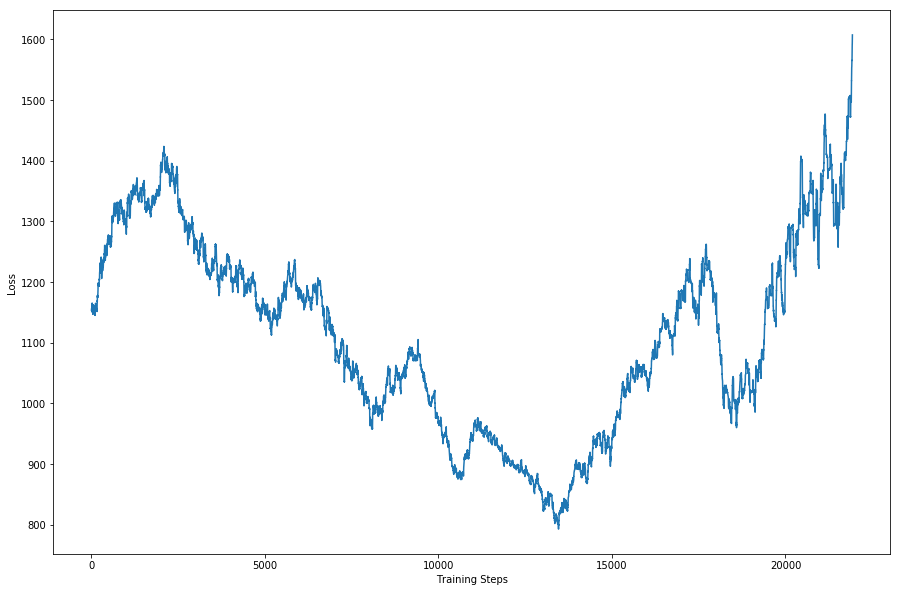

In [83]:
plt.figure(figsize=(15,10))
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.plot(running_mean(losses, 500))
#plt.savefig("dqn_3_loss_plot.pdf", format="pdf")